# Assignment based on Tutorial II: Fully connected NNs
Loading Losses and Accuracies in the Final Script for presenting the results of the training in graphs

## 1. Load Losses and Accuracies 



In [25]:
import json

# Load results for each model
with open('baseline_results.json', 'r') as f:
    baseline_results = json.load(f)
    
with open('testB_results.json', 'r') as f:
    testB_results = json.load(f)

with open('testC_results.json', 'r') as f:
    testC_results = json.load(f)

with open('testD_results.json', 'r') as f:
    testD_results = json.load(f)

with open('testE_results.json', 'r') as f:
    testE_results = json.load(f)


# Extract losses and accuracies for plotting
baseline_train_losses = baseline_results['train_losses']
baseline_test_losses = baseline_results['test_losses']
baseline_epoch_accuracies = baseline_results['epoch_accuracies']
baseline_final_accuracy = baseline_results['final_accuracy']

testB_train_losses = testB_results['train_losses']
testB_test_losses = testB_results['test_losses']
testB_epoch_accuracies = testB_results['epoch_accuracies']
testB_final_accuracy = testB_results['final_accuracy']

testC_train_losses = testC_results['train_losses']
testC_test_losses = testC_results['test_losses']
testC_epoch_accuracies = testC_results['epoch_accuracies']
testC_final_accuracy = testC_results['final_accuracy']

testD_train_losses = testD_results['train_losses']
testD_test_losses = testD_results['test_losses']
testD_epoch_accuracies = testD_results['epoch_accuracies']
testD_final_accuracy = testD_results['final_accuracy']

testE_train_losses = testE_results['train_losses']
testE_test_losses = testE_results['test_losses']
testE_epoch_accuracies = testE_results['epoch_accuracies']
testE_final_accuracy = testE_results['final_accuracy']


## 2. Plotting the Epoch Losses

In [26]:
import matplotlib.pyplot as plt

# 10 epochs for all models
epochs = list(range(1, 11))

plt.figure(figsize=(10, 5))

# Plot losses for the baseline model
plt.plot(epochs, baseline_train_losses, label='Baseline - Train Loss')
plt.plot(epochs, baseline_test_losses, label='Baseline - Test Loss')

# Plot losses for Test B model
plt.plot(epochs, testB_train_losses, label='Test B - Train Loss')
plt.plot(epochs, testB_test_losses, label='Test B - Test Loss')

# Plot losses for Test C model
plt.plot(epochs, testC_train_losses, label='Test C - Train Loss')
plt.plot(epochs, testC_test_losses, label='Test C - Test Loss')

# Plot losses for Test D model
plt.plot(epochs, testD_train_losses, label='Test D - Train Loss')
plt.plot(epochs, testD_test_losses, label='Test D - Test Loss')

# Plot losses for Test E model
plt.plot(epochs, testE_train_losses, label='Test E - Train Loss')
plt.plot(epochs, testE_test_losses, label='Test E - Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Losses Over Epochs')
plt.legend()
plt.show()

## 3. Load the data

First we will load the data: 60000 training images and 10000 images for validation with some included data transformations.Each image is a 28x28 pixels. For this model we will interpret it as a 1D array of 784 elements.Note: The images are originally 28x28 pixels. Since a neural network expects a flat array of features (a 1D vector), each 28x28 image needs to be transformed into a 1D array of 784 elements (since 28×28=784).

In [27]:
# Define the transformation to normalize the data
transform = transforms.Compose([transforms.ToTensor(), # Converts the PIL Image to a tensor. This also converts the pixel values from 0-255 to 0-1.
                                transforms.Normalize((0.5,), (0.5,))]) # Normalizes the tensor with mean 0 and standard deviation 1.
                                

# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/FMNIST_data/', download=True, train=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/FMNIST_data/', download=True, train=False, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=True)

# Print shapes of the datasets
print('Train dataset shape:', len(trainset), 'total images and labels')
print('Test dataset shape:', len(testset), 'total images and labels') #will return 60,000, and len(testset) will return 10,000.

Train dataset shape: 60000 total images and labels
Test dataset shape: 10000 total images and labels


In [28]:
#Looping Over the Dataset
for el in trainset:
  x, y = el
  print(x.shape, y)
  break

torch.Size([1, 28, 28]) 9


In [29]:
for el in trainloader:
  x, y = el 
  print(x.shape, y.shape) 
  break

torch.Size([64, 1, 28, 28]) torch.Size([64])


### Adding this function with a Quick Inspection here, with purpose to visually confirm that the manually expanded images are appearing as intended before they are used in training.

torch.Size([64, 1, 28, 28]) torch.Size([64])


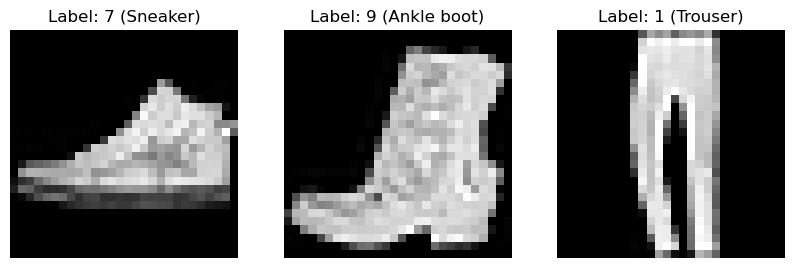

In [30]:
# Define the class names for FashionMNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Quick inspection of augmented images
def quick_inspect(loader, num_images=3):
    dataiter = iter(loader)
    images, labels = next(dataiter)
    plt.figure(figsize=(10, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i].numpy().reshape(28, 28), cmap='gray')
        # Display both the label index and the corresponding class name
        plt.title(f'Label: {labels[i].item()} ({class_names[labels[i].item()]})')
        plt.axis('off')
    plt.show()

# Print the shape of one batch from the expanded dataset
for el in trainloader:  # Use expanded_loader instead of trainloader
    x, y = el
    print(x.shape, y.shape)
    break

# Use the quick inspection function if needed
quick_inspect(trainloader)

## 6. Bulding a neural network

Number of inputs for neurons will be given by input data, i.e. image dims (flattened), size. Output - by number of classes, 10 in our case.

In [31]:
model = MyModel(n_input=784, n_hiddens=[1500], n_output=10)  # n_hiddens=[1500] is list with one element indicating the single hidden layer with 1500 neurons

In [32]:
# Function to get the number of parameters
def get_npars(model):
    """
    Returns the total number of trainable parameters in the given PyTorch model.
    """
    n = np.sum([np.prod(list(p.shape)) for p in model.parameters()])
    return int(n)

# Get and print the number of parameters in the model
num_parameters = get_npars(model)
print(f'The model has {num_parameters} trainable parameters.')


The model has 1192510 trainable parameters.


In [33]:
# Loss function
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # weight decay for regularization

#Weight Decay introduces L2 regularization, which adds a penalty to the loss function based on the size of the model's weights. This penalty discourages the model from learning overly complex patterns that might not generalize well to new data.
#weight_decay=1e-5: weight_decay parameter controls the strength of this regularization, small value like 1e-5 good starting point.


Defining a training function:

In [34]:
def train(model, trainloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for images, labels in trainloader:
        optimizer.zero_grad()  
        output, _, _ = model(images) 
        loss = criterion(output, labels) 
        loss.backward()  
        optimizer.step()  
        running_loss += loss.item() 
    return running_loss / len(trainloader) 

Defining a testing function:

In [35]:
def test(model, testloader, criterion):
    model.eval()
    running_loss = 0.0
    n_correct = 0
    n_samples = 0 

    with torch.no_grad(): 
        for images, labels in testloader:
            output, prob, pred = model(images)
            loss = criterion(output, labels) 
            running_loss += loss.item()

            correct = torch.sum(pred == labels) 
            n_correct += correct.item() 
            n_samples += labels.size(0)  

    accuracy = n_correct / n_samples  # Compute overall accuracy
    return running_loss / len(testloader), accuracy

In [36]:
testloader.batch_size

64

Training the model

In [37]:
# Lists to store losses and accuracy for Test D model
train_losses_testD = []
test_losses_testD = []
test_accuracies_testD = []  

num_epochs = 10 # Number of epochs for training

for epoch in range(num_epochs):
    train_loss = train(model, trainloader, criterion, optimizer)
    test_loss, test_accuracy = test(model, testloader, criterion)  # Assuming test returns loss and accuracy

   # Store losses for Test D model
    train_losses_testD.append(train_loss)
    test_losses_testD.append(test_loss)

     # Store accuracy for Test D model
    test_accuracies_testD.append(test_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Epoch 1/10, Train Loss: 0.5510, Test Loss: 0.4270, Test Accuracy: 0.8443
Epoch 2/10, Train Loss: 0.4510, Test Loss: 0.4498, Test Accuracy: 0.8421
Epoch 3/10, Train Loss: 0.4244, Test Loss: 0.3895, Test Accuracy: 0.8597
Epoch 4/10, Train Loss: 0.4024, Test Loss: 0.3975, Test Accuracy: 0.8560
Epoch 5/10, Train Loss: 0.3870, Test Loss: 0.3750, Test Accuracy: 0.8653
Epoch 6/10, Train Loss: 0.3782, Test Loss: 0.3713, Test Accuracy: 0.8671
Epoch 7/10, Train Loss: 0.3637, Test Loss: 0.3870, Test Accuracy: 0.8578
Epoch 8/10, Train Loss: 0.3575, Test Loss: 0.3728, Test Accuracy: 0.8641
Epoch 9/10, Train Loss: 0.3532, Test Loss: 0.3569, Test Accuracy: 0.8738
Epoch 10/10, Train Loss: 0.3426, Test Loss: 0.3632, Test Accuracy: 0.8687


Visualize the loss curves

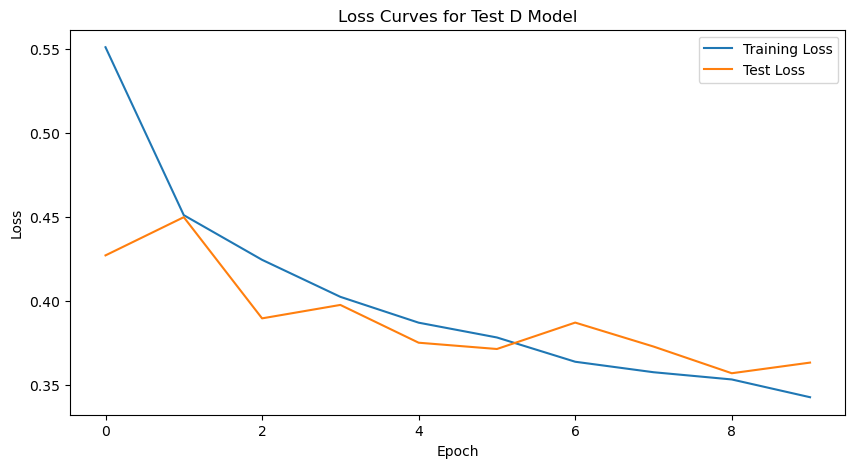

In [38]:
# Plotting the loss curves for the Test D model
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(num_epochs), train_losses_testD, label='Training Loss')
ax.plot(range(num_epochs), test_losses_testD, label='Test Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(loc='upper right')
ax.set_title('Loss Curves for Test D Model')
plt.show()

In [39]:
for p in model.parameters():
  print(np.prod(list(p.shape)))

1176000
1500
15000
10


In [40]:
def get_predictions(model, loader):
    model.eval()
    predictions = []
    labels = []
    images_list = []
    with torch.no_grad():
        for images, label in loader:
            output, _, _ = model(images)
            pred = output.argmax(dim=1)
            predictions.extend(pred.tolist())
            labels.extend(label.tolist())
            images_list.extend(images)
    return predictions, labels, images_list

def calculate_accuracy(predictions, labels):
    correct = sum(pred == label for pred, label in zip(predictions, labels))
    total = len(labels)
    accuracy = correct / total
    return accuracy

# Get predictions, labels, and images
predictions, labels, images_list = get_predictions(model, testloader)
correct = [pred == label for pred, label in zip(predictions, labels)]

accuracy = calculate_accuracy(predictions, labels)

print(f"Accuracy: {accuracy}")

Accuracy: 0.8687


Aggregate a correct and incorrect example and visualize:

First incorrect digit is at index: 15


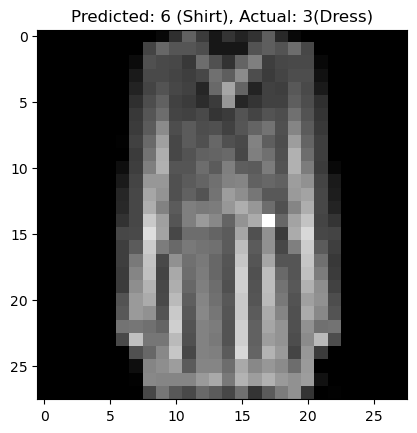

First correct digit is at index: 0


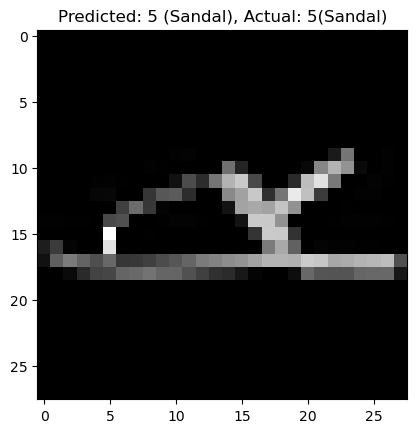

In [19]:

# Find the index of the first incorrect and correct prediction
wrong_idx = next((i for i, correct in enumerate(correct) if not correct), None)
correct_idx = next((i for i, correct in enumerate(correct) if correct), None)

# Function to display an image
def display_image(image, title):
    plt.imshow(image.numpy().reshape(28, 28), cmap='gray')
    plt.title(title)
    plt.show()

# Display the first incorrect sample (if any incorrect are found)
if wrong_idx is not None:
    print(f"First incorrect digit is at index: {wrong_idx}")
    pred = predictions[wrong_idx]
    lbl  = labels[wrong_idx]
    display_image(images_list[wrong_idx], f"Predicted: {pred} ({class_names[pred]}), Actual: {lbl}({class_names[lbl]})")
else:
    print("No incorrect predictions found")

# Display the first correct sample (if any correct are found)
if correct_idx is not None:
    print(f"First correct digit is at index: {correct_idx}")
    pred = predictions[correct_idx]
    lbl  = labels[correct_idx]
    display_image(images_list[correct_idx], f"Predicted: {pred} ({class_names[pred]}), Actual: {lbl}({class_names[lbl]})")
else:
    print("No correct predictions found")

## 7. Visualizing the Parameters

torch.Size([10, 1500]) torch.Size([10])


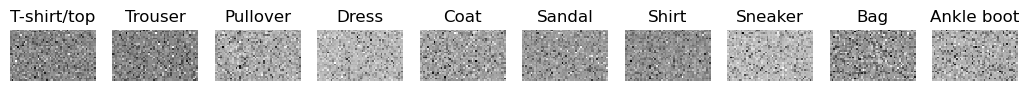

In [41]:
#inspecting and visualising the weights of the output layer
layer = model.lout 
n_features = layer.out_features 
w1, b1 = layer.weight.data, layer.bias.data #extract weights and biases from the output layer.
print(w1.shape, b1.shape) ## expecting w1 to be [n_features, 1500]

w1_reshaped = w1.view(n_features, 30, 50) #Adjust the view dimensions as per layer's configuration of 1500 neurons

# Plotting the weights
_, axs = plt.subplots(1, n_features, figsize=(13, 5))

for i in range(10): # Loop over the number of output features (classes)
    axs[i].imshow(w1_reshaped[i].numpy(), cmap='gray', interpolation='nearest')
    axs[i].grid(False)
    axs[i].axis('off')
    axs[i].set_title(f'{trainset.classes[i]}')
plt.show()

In [42]:
def get_predictions(model, loader):
    model.eval()
    predictions = []
    labels = []
    images_list = []
    with torch.no_grad():
        for images, label in loader:
            output, probs, pred = model(images)
            predictions.extend(pred.tolist())
            labels.extend(label.tolist())
            images_list.extend(images)
    return predictions, labels, images_list

def calculate_accuracy(predictions, labels):
    correct = sum(pred == label for pred, label in zip(predictions, labels))
    total = len(labels)
    accuracy = correct / total
    return accuracy



In [43]:
#generate predictions and compute the final accuracy after training the model
predictions, labels, images_list = get_predictions(model, testloader)  
accuracy = calculate_accuracy(predictions, labels)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8687


In [44]:
import datetime

# Get the current date and time for unique naming
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Define the filename using only the test name (will overwrite with each run)
test_name = "testD"  # Replace with your test name
model_filename = f'{test_name}_trained_model.pth'

# Save the model and optimizer state dicts
save_dict = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': num_epochs,
    'train_loss': train_losses_testD,
    'test_loss': test_losses_testD
}

torch.save(save_dict, model_filename)  # Add this line to actually save the dictionary
print(f'Trained model saved as {model_filename}')


Trained model saved as testD_trained_model.pth


In [45]:
# Code for Storing Results in JSON Files
import json

# Store the results (losses and accuracy) in a dictionary
results = {
    'train_losses': train_losses_testD,  
    'test_losses': test_losses_testD,    
    'test_accuracies': test_accuracies_testD, 
    'final_accuracy': test_accuracies_testD[-1]  # Store the final accuracy as a separate key
}

# Save results to a JSON file, overwrite each time
json_filename = f'{test_name}_results.json'  # No timestamp to allow overwriting
with open(json_filename, 'w') as f:
    json.dump(results, f)
print(f'Results saved in {json_filename}')


Results saved in testD_results.json
